# **Initial Steps**

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"10TVpC4_CV-h4o2U3P7KjGdvbsiuFFnkN"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Train.xlsx')

ModuleNotFoundError: No module named 'pydrive'

### Libraries, Packages and others

In [1]:
pip install category_encoders

In [2]:
import pandas as pd
import datetime
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from math import ceil
# from pandas_profiling import ProfileReport
import scipy.cluster.hierarchy as shc
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder





# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'


import warnings
warnings.filterwarnings("ignore")

###Functions 

In [3]:
def birthday_to_age(df, column, new_column):
    '''
    This function creates a column representing the difference in years from a given birth year column values
    Having into account that we are on the year 2048
    '''
    
    df[new_column] = df[column].map(lambda x : 2048 - x)
    
def questionmark_to_nan(df, column):
    '''
    This function turns a binary variable with missing values as '?' in NaN
    It needs as input the dataframe and the column name 
    (column name needs to be between '')
    '''
    df[column] = df[column].map(lambda x: np.nan if x == '?' else x)
    
def ohe(df, column_list):
    ohc = OneHotEncoder(sparse = False)
    ohc_feat = ohc.fit_transform(df[column_list])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index = df.index, columns = ohc_feat_names)
    return ohc_df

def hist_box_maker(df,titl, num_of_rows, figx, figy):
    
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        
        if i%2 == 0:
            ax.hist(df[feat], bins = 50)
            ax.set_title(feat, y=-0.13)
            pltiswork=feat
            
        else:
            sns.boxplot(x=df[pltiswork], ax = ax)
        
        i+=1
            
    # Layout
    # Add a centered title to the figure:
    title = titl

    plt.suptitle(title)

    plt.show()# All Numer

### Import data

In [4]:
train = pd.read_excel("Train.xlsx")

# **Data Inspection**

In [5]:
train.head() #Data was imported correctly

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [6]:
 #No column seems to have, for now, a wrong dtype, except Birthday
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [7]:
train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


In [8]:
train.isna().sum() #No "immediate" missing values

CITIZEN_ID                0
Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

### Data Treatment


#### Categorical Variables Treatment

Lets start to treat the object type variables.

Remember that no variables seemed to show missing values.

In [10]:
for i in ["Name", "Native Continent", "Marital Status", "Lives with", "Base Area", "Education Level", "Employment Sector", "Role"]:
    train[i] = train[i].astype("str")

In [11]:
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [12]:
#All seems fine.
#However in order to use Native Continent on our models we will need to later perform one hot encoding.
#We can't use label encoding since the categories aren't ordered and we would be inducing orders or hierarchies were they don't exist.
train['Native Continent'].value_counts()

Europe     19111
Africa      2187
Asia         699
America      219
Oceania      184
Name: Native Continent, dtype: int64

In [13]:
#This values can be turned into binary variables which describe if the person is married, not married (anymore), or never married.
#This will allow us to have a better significance in our resuls (meaning, not a huge amount of 0s in binary variables), which we would
#have if we proceed to make one hot encoding right now. 
#We will make this change later in the feature engineering step.
train['Marital Status'].value_counts()

Married                         10219
Single                           7416
Divorced                         3072
Separated                         699
Widow                             696
Married - Spouse Missing          284
Married - Spouse in the Army       14
Name: Marital Status, dtype: int64

In [14]:
#This values can be turned into binary variables. For being able to do so, we will primarily turn the values "Husband" and "Wife" in "Spouse" and "Other Family"
#and "Other relatives" in only 1 value as they seem to have the same meaning.
#We will make this change later in the feature engineering step.
train['Lives with'].value_counts()

Wife               9012
Other Family       5777
Children           3519
Alone              2362
Husband            1049
Other relatives     681
Name: Lives with, dtype: int64

In [15]:
#We have '?' values, wich are clearly missing values, so we have to turn them into ones
#With the high number of missing values, we will probably need to use techniques to fill missing values, for example, the KNN
#We also believe we cannot make one hot encoding in this variable otherwise we would create too many variables and they would loose their significance
#However, it is important to highlight that we have a lot of observations with the value Northbury, which means that if we have to make only a binary column
#with this variable it will have a good representation on the dataset.
train['Base Area'].value_counts() 

Northbury        20074
Fanfoss            443
?                  395
Alverton           135
Butterpond          96
Watford             83
Auchenshuggle       80
Pran                77
Sharnwick           70
Aroonshire          64
Laewaes             63
Fool's March        59
Eelry               56
Wigston             56
Sharpton            54
Lanercost           52
Cherrytown          51
Aerilon             45
King's Watch        44
Kirkwall            40
Bellmoral           40
Knife's Edge        37
Laenteglos          32
Tranmere            30
Drumchapel          25
Aberuthven          23
Orilon              22
Kald                19
Carlisle            18
MillerVille         17
Willesden           16
Lewes               16
Conriston           12
Marnmouth           11
Middlesbrough       10
Mensfield            9
Woodpine             9
Bellenau             8
Redwick Bush         8
Ironforge            1
Name: Base Area, dtype: int64

In [16]:
#The categories seem to be good! We believe that a distinction as deep as the one presented is not needed, and so, we will
#group some variables as the latest education a person has received.
#As we are dealing with Ordinal data, meaning, the variables have a natural order, for example, a PhD is valued higher than a high school degree, 
#We will create a variable that contains the categories representing the education qualification, in integer values, as the algorithm can process
#these values as an order
#We will make this change later in the feature engineering step.
train['Education Level'].value_counts() 

Professional School                     7232
High School + PostGraduation            4994
Bachelors + PostGraduation              3696
Masters                                 1193
Professional School + PostGraduation     953
High School - 2nd Cycle                  809
Bachelors                                735
High School - 1st Cycle                  649
Middle School - 2nd Cycle                432
Masters + PostGraduation                 397
Middle School Complete                   342
PhD                                      289
High School Complete                     287
Middle School - 1st Cycle                237
Primary School                           122
Preschool                                 33
Name: Education Level, dtype: int64

In [17]:
#Has the same missing values problem as before, meaning, when there is missing data it is represented by a "?"
#The categories have information about big groups of values (private sector, public sector, etc), so we will retrieve this information in 
#a more correct and larger way.
#After doing so, we will probably have to reach to some type of data encoding technique in order to be able to use this information in our model
#We will make this change later in the feature engineering step.
train['Employment Sector'].value_counts() 

Private Sector - Services     15599
Self-Employed (Individual)     1764
Public Sector - Others         1419
?                              1264
Private Sector - Others         880
Self-Employed (Company)         763
Public Sector - Government      692
Unemployed                       12
Never Worked                      7
Name: Employment Sector, dtype: int64

In [18]:
#Has the same missing values problem as before, meaning, when there is missing data it is represented by a "?"
#The grouping of information (in order to be able to have encoding) in this variable is difficult to tackle.
#We will probably use the sectors of the economy to make some type of encoding in this variable
#We will make this change later in the feature engineering step.
train['Role'].value_counts() 

Professor                         2849
Management                        2797
Repair & constructions            2795
Administratives                   2608
Sales                             2531
Other services                    2287
Machine Operators & Inspectors    1384
?                                 1271
Transports                        1071
Cleaners & Handlers                922
Agriculture and Fishing            702
IT                                 626
Security                           450
Household Services                 102
Army                                 5
Name: Role, dtype: int64

In [19]:
#As the name is not very important in our analysis, we will proceed on removing the first word from the name, meaning, the gender the person
#identifies with and we will create a variable with information about the gender.
#We will make this change later in the feature engineering step.
train['Name'].head()

0         Mr. Adam Glover
1    Mr. Cameron McDonald
2      Mr. Keith Davidson
3      Mr. Alexander Gill
4          Mr. Neil Piper
Name: Name, dtype: object

In [20]:
#Clearly some transformations are needed, if we want to use this variable
#We will have to do some engineering 
train['Birthday'].head() 

0         July 1,2003
1     January 25,2006
2         May 10,2009
3       March 25,1985
4         May 29,2015
Name: Birthday, dtype: object

In [21]:
#Turning the "?" in missing value np.nan
questionmark_to_nan(train, 'Base Area') 
questionmark_to_nan(train, 'Employment Sector') 
questionmark_to_nan(train, 'Role') 

#Checking whether there are more categorical variables with "?" values
for i in ["Name", "Native Continent", "Marital Status", "Lives with", "Base Area", "Education Level", "Employment Sector", "Role"]:
  print(train[i].str.contains('?', regex = False).sum())

0
0
0
0
0
0
0
0


#### Numeric Variables Treatment

Since no variables showed *immediate* missing values, on the variables whose data type is float or int, we know that we won't have the problem of '?' missing values, otherwise the variables would be of object data type.

However we still have to check these variables to know if there are some immediate incoherences.

In [22]:
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [23]:
#No repeated Citizen ID's
(train['CITIZEN_ID'].value_counts()>1).sum() 

0

**Assumption:**If the Citizen ID follows the normal order of atribution of ID after being recognized the citizenship, we know which citizens were the first to arrive, as their ID's will have a smaller value.

In [24]:
#??????
#train.drop(columns = ['CITIZEN_ID']).describe()

# **Coherence Checks**

In [25]:
#It makes no sense to have negative values in the following numerical variables.
print("Number of negative values:")
for i in ["Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]:
  print(i,":", ((train[i]<0).sum()))
#All seems to be good!

Number of negative values:
Years of Education : 0
Working Hours per week : 0
Money Received : 0
Ticket Price : 0
Income : 0


No values below 0. For now everything looks fine.

Considering the average, std and min and max values of *Years of Education* and *Working Hours per week*, there definitely seem to be some outliers, but we will check this with more detail later. Since most values of *Money Received* and *Ticket Price* are 0, we can't talk about its outliers right now.

In [26]:
train[(train['Money Received']<0) & (train['Ticket Price']>0)] 

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income


In the clause above we can see that there are no records that show people that have simultanously paid to go to Newland (belonging to Group C) and that have been paid to go to Newland (therefore belonging to Group B)

In [27]:
train[(train['Money Received']==0) & (train['Ticket Price']==0)].shape[0]

19511

There are 19511 people that were neither paid or payed to go to Newland

In [28]:
train[(train['Money Received']<=0) & (train['Ticket Price']>=0)].shape[0]

20568

This shows us that the data for these columns is correct! 

# **Data Transformation**

#### Birthday to age transformation

We have the birthday of each person, but more usefull to estimate the model is their age.

However before we calculate the age we have to do some transformations to the birthday variable.

We will calculate the age having in to account that we are on the year 2048, and we don't know the current month or day.

In [29]:
train['Birthday'].head()

0         July 1,2003
1     January 25,2006
2         May 10,2009
3       March 25,1985
4         May 29,2015
Name: Birthday, dtype: object

In [30]:
#First we extract the year of each birthday in to a new column
train["YOB"] = train['Birthday'].str.split(' ', n = 2, expand = True)[2].str.split(',', n = 1, expand = True)[1]

In [31]:
train["YOB"].head()

0    2003
1    2006
2    2009
3    1985
4    2015
Name: YOB, dtype: object

In [32]:
train['YOB'] = train['YOB'].astype('int64') #Turns year of birth in to dtype int

In [33]:
birthday_to_age(train, 'YOB', 'Age') #Turns year of birth to age

In [34]:
train[['Age']].describe().T #All seems fine

,count,mean,std,min,25%,50%,75%,max
Age,22400.0,38.584866,13.651578,17.0,28.0,37.0,48.0,90.0


In [35]:
#And we drop the columns we will no longer need
train.drop(columns = ['Birthday', 'YOB'], inplace = True)

#### Base Area -> Northbury

There are a lot of base areas, however most observations belong to Northbury, so instead of using one hot encoding and proceding with all the values, we will just proced with a variable that signals whether the person is of Northbury or not.

MESMO ASSIM SERIA FIXE FAZER ONE HOT ENCODING E DPS FEATURE SELECTION PARA GARANTIR QUE REALMENTE SO A NORTHBURY DEVA FICAR

In [36]:
train['Northbury'] = train['Base Area'].map(lambda x: 1 if x == 'Northbury' else 0)

#Não esquecer fazer inut NA antes disto
#No entnto pode não ser necessário!!!!!!!!!!!!!!!!!!

In [37]:
train['Northbury'].value_counts()

1    20074
0     2326
Name: Northbury, dtype: int64

In [38]:
train.drop(columns = ['Base Area'], inplace = True)

#### Name -> Gender -> Male

It doesn't make sense to model using the different names in the dataset, however with the first byte of each one (for example: Mrs.) we can conclude quite easily the gender of each person. Having the gender we can then create a variable that signals all the males.

In [39]:
train['Gender'] = train['Name'].str.split(' ', n = 1, expand = True)[0] 

In [40]:
train['Gender'].value_counts()

Mr.     14971
Mrs.     4117
Miss     3312
Name: Gender, dtype: int64

In [41]:
train['Male'] = train['Gender'].map(lambda x: 1 if x == 'Mr.' else 0)

In [42]:
train['Male'].value_counts()

1    14971
0     7429
Name: Male, dtype: int64

In [43]:
train.drop(columns = ['Name', 'Gender'], inplace = True)

### *Lives with* and *Marital Status*


In [44]:
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Married' if ((x == 'Married - Spouse Missing') | (x == 'Married - Spouse in the Army') ) else x)
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Not Married' if ((x == 'Divorced')  | (x == 'Separated') | (x == 'Widow')) else x)
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Never Married' if ((x == 'Single') ) else x)

There are no weird values and one hot encoding will be needed for the same reasons as in the previous variable.

However some values seem to specific and have very little representation on the observations, so we will "standardize" this values: "Married - Spouse Missing" and "Married - Spouse in the Army" will be changed to "Married".

There is no point in discretizing between living with Wife or Husband, so we will aggregate it in Spouse. Same thing with other relatives and Other Family.

In [45]:
train['Lives with'] = train['Lives with'].map(lambda x: 'Spouse' if ((x == 'Wife') | (x == 'Husband')) else x)
train['Lives with'] = train['Lives with'].map(lambda x: 'Other Family' if (x == 'Other relatives') else x)

In [46]:
train.dtypes

CITIZEN_ID                 int64
Native Continent          object
Marital Status            object
Lives with                object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
Age                        int64
Northbury                  int64
Male                       int64
dtype: object

### Education Level

- https://en.wikipedia.org/wiki/Education_in_the_United_States
- http://internacional.ipvc.pt/sites/default/files/Diagrama_SESP_EQF_PT1.pdf
- https://europa.eu/europass/pt/description-eight-eqf-levels

In [47]:
#Division will have to be made top to bottom. Meaning, if it appears "Masters" and "PostGraduation",
#we will treat first "Masters" to make sure we have the maximum education first
train["Education Level"].value_counts()

Professional School                     7232
High School + PostGraduation            4994
Bachelors + PostGraduation              3696
Masters                                 1193
Professional School + PostGraduation     953
High School - 2nd Cycle                  809
Bachelors                                735
High School - 1st Cycle                  649
Middle School - 2nd Cycle                432
Masters + PostGraduation                 397
Middle School Complete                   342
PhD                                      289
High School Complete                     287
Middle School - 1st Cycle                237
Primary School                           122
Preschool                                 33
Name: Education Level, dtype: int64

In [48]:
#Solução 1 - Fazer por grupos que nós considerarmos certos. Aqui estão os que eu acho que ficam bem, mas é perfeitamente alterável
train['Education Level'] = train['Education Level'].map(lambda x: 'Masters' if ("Masters" in x) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'PostGraduation' if ("PostGraduation" in x) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'Incomplete High School' if ((x== "High School - 2nd Cycle") | (x== "High School - 1st Cycle")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'Less than Middle School' if ((x=="Middle School - 2nd Cycle") | (x== "Middle School - 1st Cycle") | (x== "Primary School") |(x== "Preschool" )) else x)
train['Education Level'] = train['Education Level'].map(lambda x: '<HighSchool' if ((x=="Incomplete High School") | (x== "Less than Middle School") | (x== "Middle School Complete")) else x)
train["Education Level"].value_counts()

PostGraduation          9643
Professional School     7232
<HighSchool             2624
Masters                 1590
Bachelors                735
PhD                      289
High School Complete     287
Name: Education Level, dtype: int64

In [49]:
#Solução 2 - Fazer por grupos instituidos pela UE (ver link acima). Se assim o fizermos, sabemos por exemplo que a professional school está acima da highschool!
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF3 or less' if ((x=="<HighSchool")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF4' if ((x=="High School Complete")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF5' if ((x=="Professional School")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF6' if ((x=="Bachelors")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF7' if ((x=="Masters") | (x== "PostGraduation")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF8' if ((x=="PhD")) else x)
train["Education Level"].value_counts()

EQF7            11233
EQF5             7232
EQF3 or less     2624
EQF6              735
EQF8              289
EQF4              287
Name: Education Level, dtype: int64

### Profession


In [50]:
train["Employment Sector"] = train["Employment Sector"].astype("str")
train["Employment Sector"].value_counts()

Private Sector - Services     15599
Self-Employed (Individual)     1764
Public Sector - Others         1419
nan                            1264
Private Sector - Others         880
Self-Employed (Company)         763
Public Sector - Government      692
Unemployed                       12
Never Worked                      7
Name: Employment Sector, dtype: int64

In [51]:
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Private Sector' if ("Private Sector" in x) else x)
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Public Sector' if ("Public Sector" in x) else x)
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Self Employed' if ("Self-Employed" in x) else x)
train['Employment Sector'] = train['Employment Sector'].map(lambda x: 'Not Working' if ((x=="Unemployed") | (x== "Never Worked")) else x)
train['Employment Sector'] = train['Employment Sector'].map(lambda x: np.nan if ((x=="nan")) else x)

In [52]:
train["Employment Sector"].value_counts()

Private Sector    16479
Self Employed      2527
Public Sector      2111
Not Working          19
Name: Employment Sector, dtype: int64

### Role

In [53]:
train["Role"].value_counts()

Professor                         2849
Management                        2797
Repair & constructions            2795
Administratives                   2608
Sales                             2531
Other services                    2287
Machine Operators & Inspectors    1384
Transports                        1071
Cleaners & Handlers                922
Agriculture and Fishing            702
IT                                 626
Security                           450
Household Services                 102
Army                                 5
Name: Role, dtype: int64

In [54]:
## Primário: Agriculture and Fishing, 
## Secundário:Repair & constructions, Machine Operators & Inspectors,
## Terciário: Administratives, Sales, Other services, Transports, Cleaners & Handlers, Household Services, Security, Army  
## Quaternário: IT, Professor, Management

In [55]:
train["Role"]= train["Role"].map(lambda x: '1st Sector' if ((x=="Agriculture and Fishing")) else x)
train["Role"]= train["Role"].map(lambda x: '2nd Sector' if ((x=="Repair & constructions") | (x== "Machine Operators & Inspectors"))else x)
train["Role"]= train["Role"].map(lambda x: '3rd Sector' if ((x== "Administratives")| (x== "Sales")| (x== "Other services")| (x== "Transports")| (x== "Cleaners & Handlers")| (x== "Household Services")| (x== "Security")| (x== "Army"))else x)
train["Role"]= train["Role"].map(lambda x: '4th Sector' if ((x=="IT") | (x== "Professor")| (x== "Management"))else x)

In [56]:
train["Role"].value_counts()

3rd Sector    9976
4th Sector    6272
2nd Sector    4179
1st Sector     702
Name: Role, dtype: int64

### Ticket Price and Money

As for the description of the project, we have noticed that ticket price represents the information of how much someone payed to go to the planet, and, money received represents the money someone was payed to go to Newland. 

Given so, we consider that both variables represent the same thing but in different directions. We will then proceed to join both, adding the inverse sign to one of them

In [57]:
train["Money Received"] = train["Money Received"].map(lambda x: -x )

In [58]:
train["MONEY_TICKET"] =  train["Money Received"].astype(str) + train["Ticket Price"].astype(str)
train["MONEY_TICKET"] = train["MONEY_TICKET"].astype(int)

# **Missing Values Imputation**

In [59]:
((train.isna().sum())/(train.shape[0])*100)

CITIZEN_ID                0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
Age                       0.000000
Northbury                 0.000000
Male                      0.000000
MONEY_TICKET              0.000000
dtype: float64

In [60]:
train["Employment Sector"]= train["Employment Sector"].fillna(train["Employment Sector"].mode()[0])
train["Role"]= train["Role"].fillna(train["Role"].mode()[0])

In [61]:
((train.isna().sum())/(train.shape[0])*100)

CITIZEN_ID                0.0
Native Continent          0.0
Marital Status            0.0
Lives with                0.0
Education Level           0.0
Years of Education        0.0
Employment Sector         0.0
Role                      0.0
Working Hours per week    0.0
Money Received            0.0
Ticket Price              0.0
Income                    0.0
Age                       0.0
Northbury                 0.0
Male                      0.0
MONEY_TICKET              0.0
dtype: float64

# **Data Encoding**

In [62]:
train_encoding = train.copy()

In [63]:
print("Number of Categories in: ")
for ColName in train[['Native Continent','Marital Status','Lives with', "Employment Sector","Role"]]:
    print("{} = {}".format(ColName,len(train[ColName].unique())))

Number of Categories in: 
Native Continent = 5
Marital Status = 3
Lives with = 4
Employment Sector = 4
Role = 4


#### One Hot Encoding

In [64]:
one_hot_var = ohe(train_encoding, ['Native Continent', 'Marital Status', 'Lives with', "Employment Sector", "Role"])

In [65]:
train_encoding = pd.concat([train_encoding.drop(columns = ['Native Continent', 'Marital Status', 'Lives with', "Employment Sector", "Role"]), one_hot_var], axis = 1)

In [66]:
train_encoding.columns

Index(['CITIZEN_ID', 'Education Level', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price', 'Income',
       'Age', 'Northbury', 'Male', 'MONEY_TICKET', 'x0_Africa', 'x0_America',
       'x0_Asia', 'x0_Europe', 'x0_Oceania', 'x1_Married', 'x1_Never Married',
       'x1_Not Married', 'x2_Alone', 'x2_Children', 'x2_Other Family',
       'x2_Spouse', 'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
       'x3_Self Employed', 'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector'],
      dtype='object')

#### Label Encoding

In [67]:
train_encoding["Education Level"].value_counts()

EQF7            11233
EQF5             7232
EQF3 or less     2624
EQF6              735
EQF8              289
EQF4              287
Name: Education Level, dtype: int64

In [68]:
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['Education Level'],return_df=True, mapping=[{'col':'Education Level','mapping':{'EQF3 or less':0,'EQF4':1,'EQF5':2,'EQF6':3,'EQF7':4,'EQF8':5}}])

#fit and transform train data 
train_encoding = encoder.fit_transform(train_encoding)

# **Descriptive Statistics**

In [69]:
train_encoding

,CITIZEN_ID,Education Level,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Northbury,Male,...,x2_Other Family,x2_Spouse,x3_Not Working,x3_Private Sector,x3_Public Sector,x3_Self Employed,x4_1st Sector,x4_2nd Sector,x4_3rd Sector,x4_4th Sector
0,12486,4,13,40,0,2273,1,45,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,12487,2,12,40,0,0,1,42,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,12488,2,12,46,0,2321,1,39,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12489,0,11,37,-5395,0,1,63,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,12490,5,21,45,0,0,1,33,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,2,12,40,0,0,0,25,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22396,34882,2,12,35,0,0,0,23,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22397,34883,4,17,40,-2674,0,0,26,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22398,34884,4,16,90,0,0,1,37,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
train_encoding = train_encoding.rename(columns={"Native Continent": "CONTINENT", "Lives with": "LIVES_WITH", 'Education Level': "EDUCATION_LVL",
                      'Years of Education': "YEARS_EDUCATION", 'Employment Sector': "EMPLOY_SECTOR", 'Role': "ECON_SECTOR",
                      'Working Hours per week': "WORKING_HOURS", 'Income': "INCOME",'Marital Status': "MARITAL_STATUS" })

In [71]:
train_encoding.columns

Index(['CITIZEN_ID', 'EDUCATION_LVL', 'YEARS_EDUCATION', 'WORKING_HOURS',
       'Money Received', 'Ticket Price', 'INCOME', 'Age', 'Northbury', 'Male',
       'MONEY_TICKET', 'x0_Africa', 'x0_America', 'x0_Asia', 'x0_Europe',
       'x0_Oceania', 'x1_Married', 'x1_Never Married', 'x1_Not Married',
       'x2_Alone', 'x2_Children', 'x2_Other Family', 'x2_Spouse',
       'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
       'x3_Self Employed', 'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector'],
      dtype='object')

In [72]:
data_newland = train_encoding[['CITIZEN_ID', 'EDUCATION_LVL', 'YEARS_EDUCATION', 'WORKING_HOURS',
       'Money Received', 'Ticket Price', 'Age', 'Northbury', 'Male',
       'MONEY_TICKET', 'x0_Africa', 'x0_America', 'x0_Asia', 'x0_Europe',
       'x0_Oceania', 'x1_Married', 'x1_Never Married', 'x1_Not Married',
       'x2_Alone', 'x2_Children', 'x2_Other Family', 'x2_Spouse',
       'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
       'x3_Self Employed', 'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector']]
target_newland = train_encoding["INCOME"]

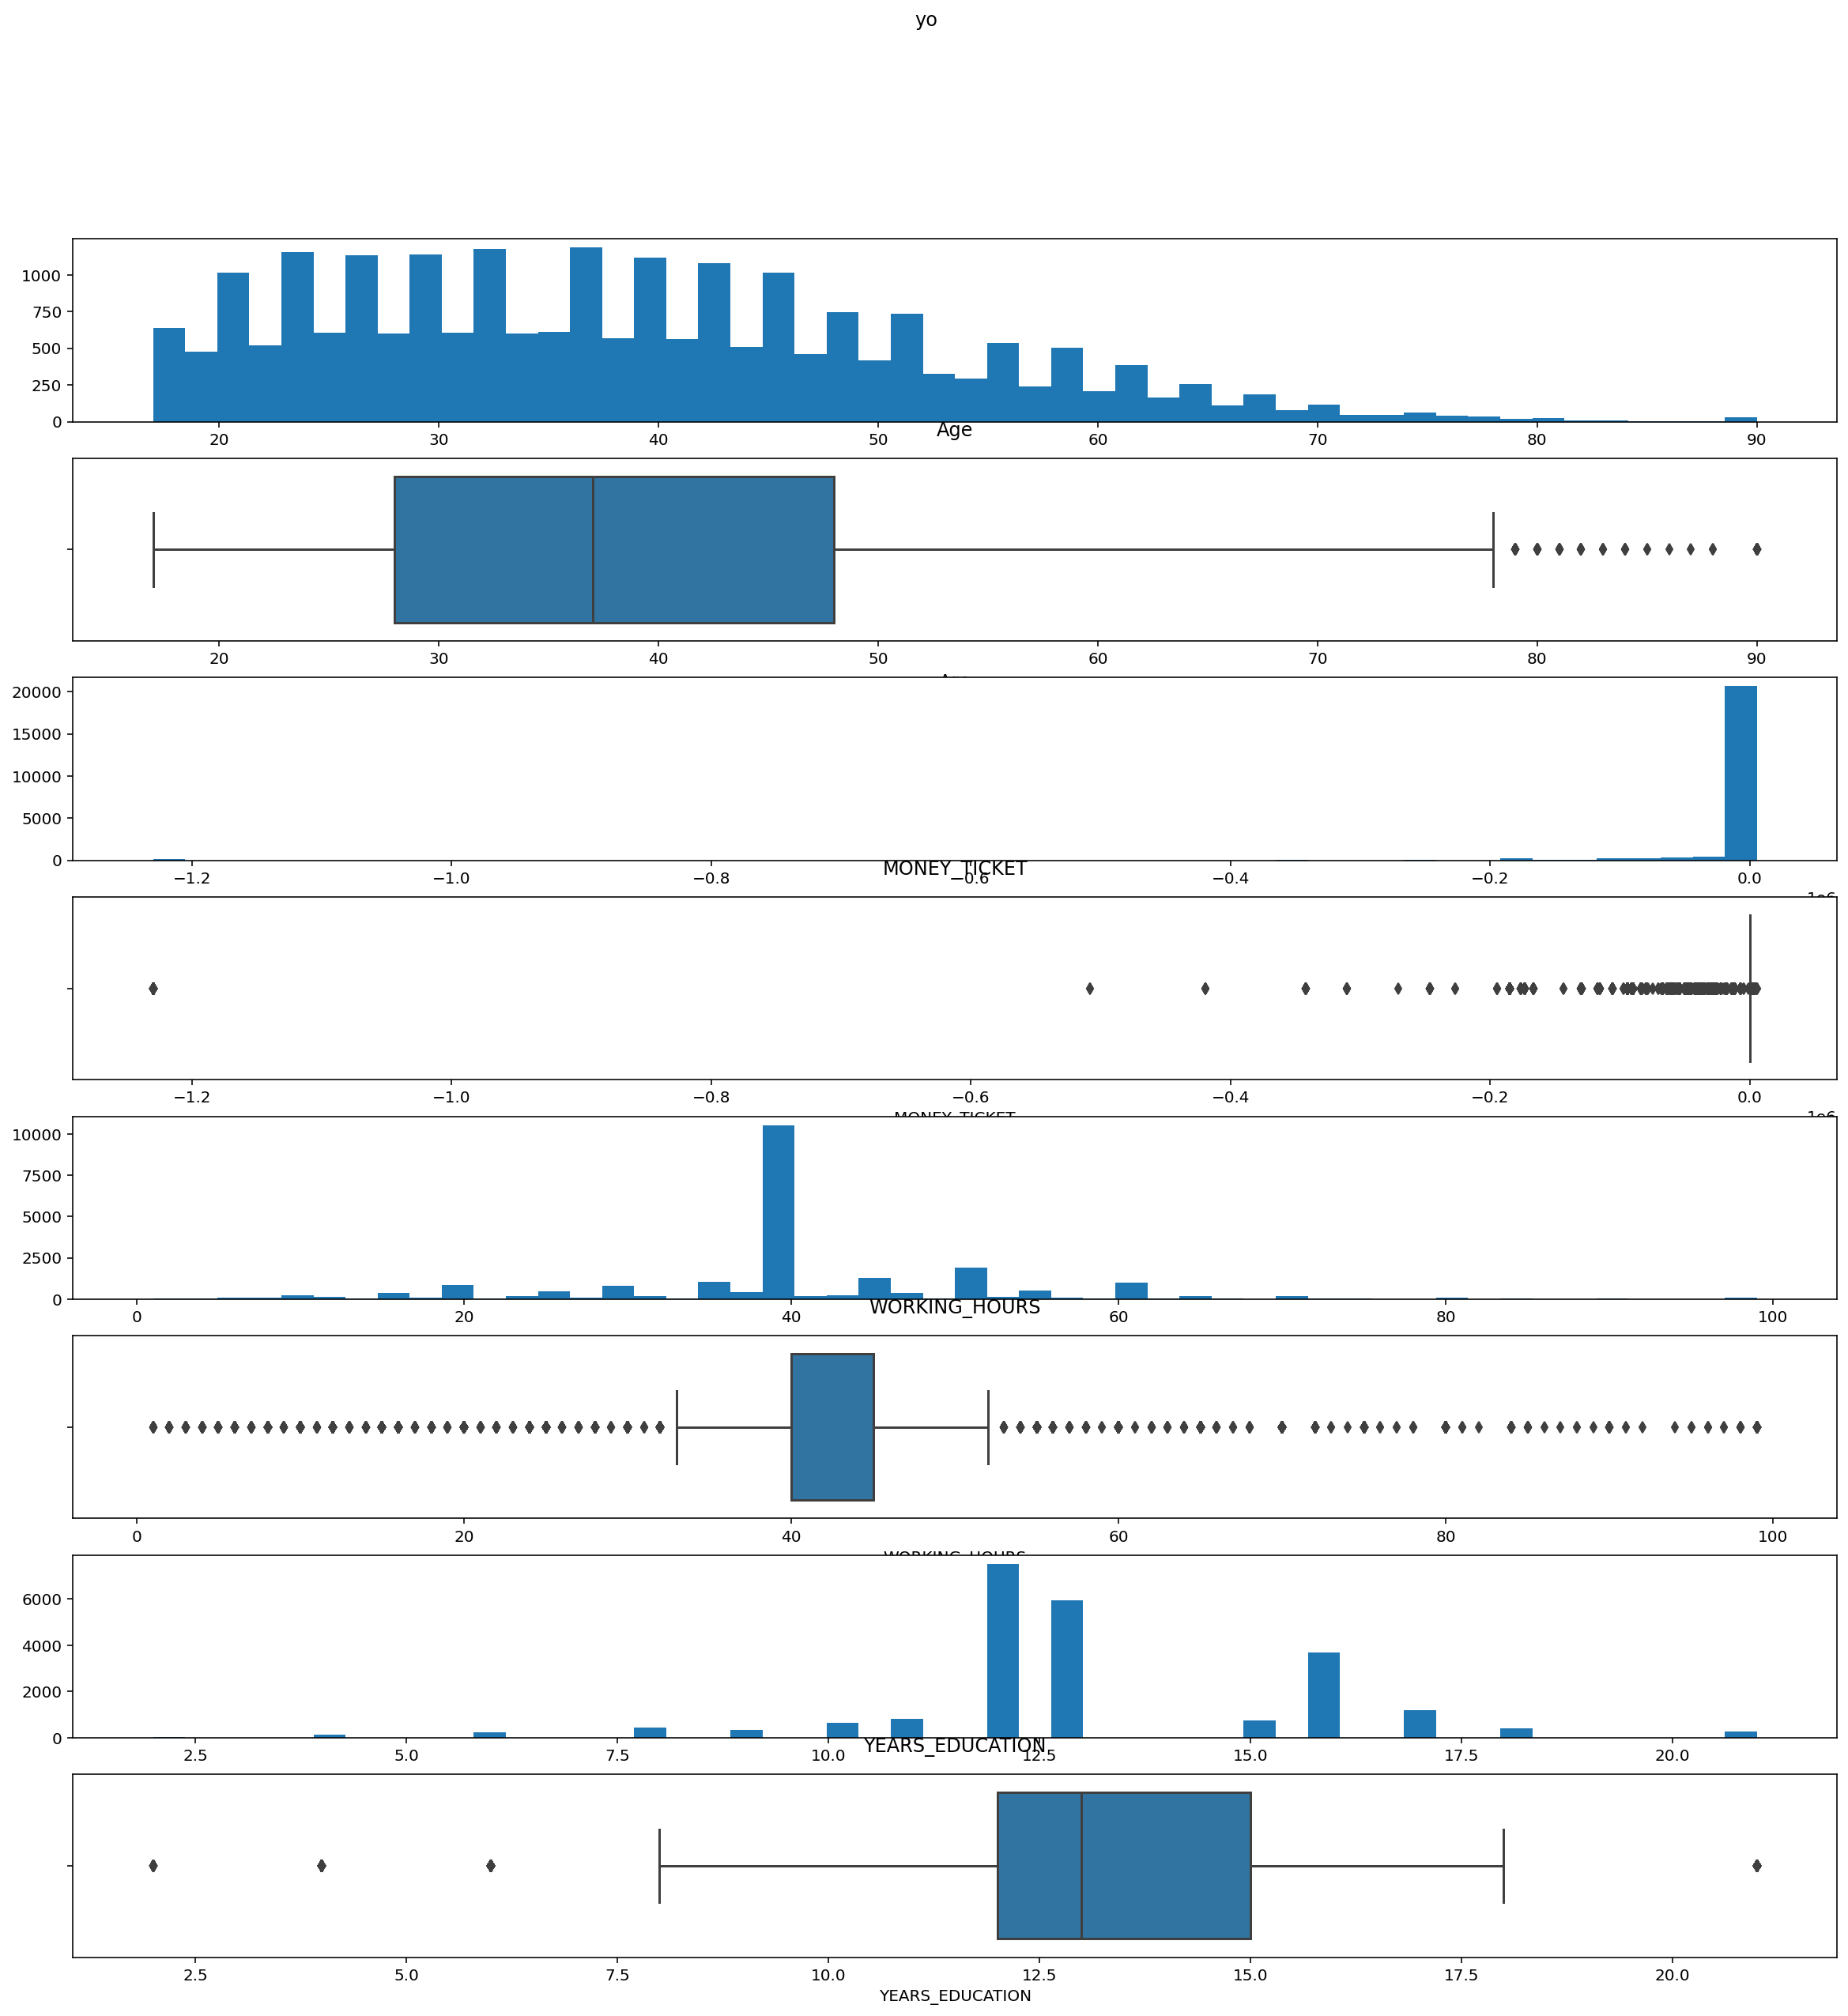

In [86]:
hist_box_maker(train_encoding[["YEARS_EDUCATION", "WORKING_HOURS", "Age", "MONEY_TICKET"]],"yo",8, 20,20)

<AxesSubplot:>

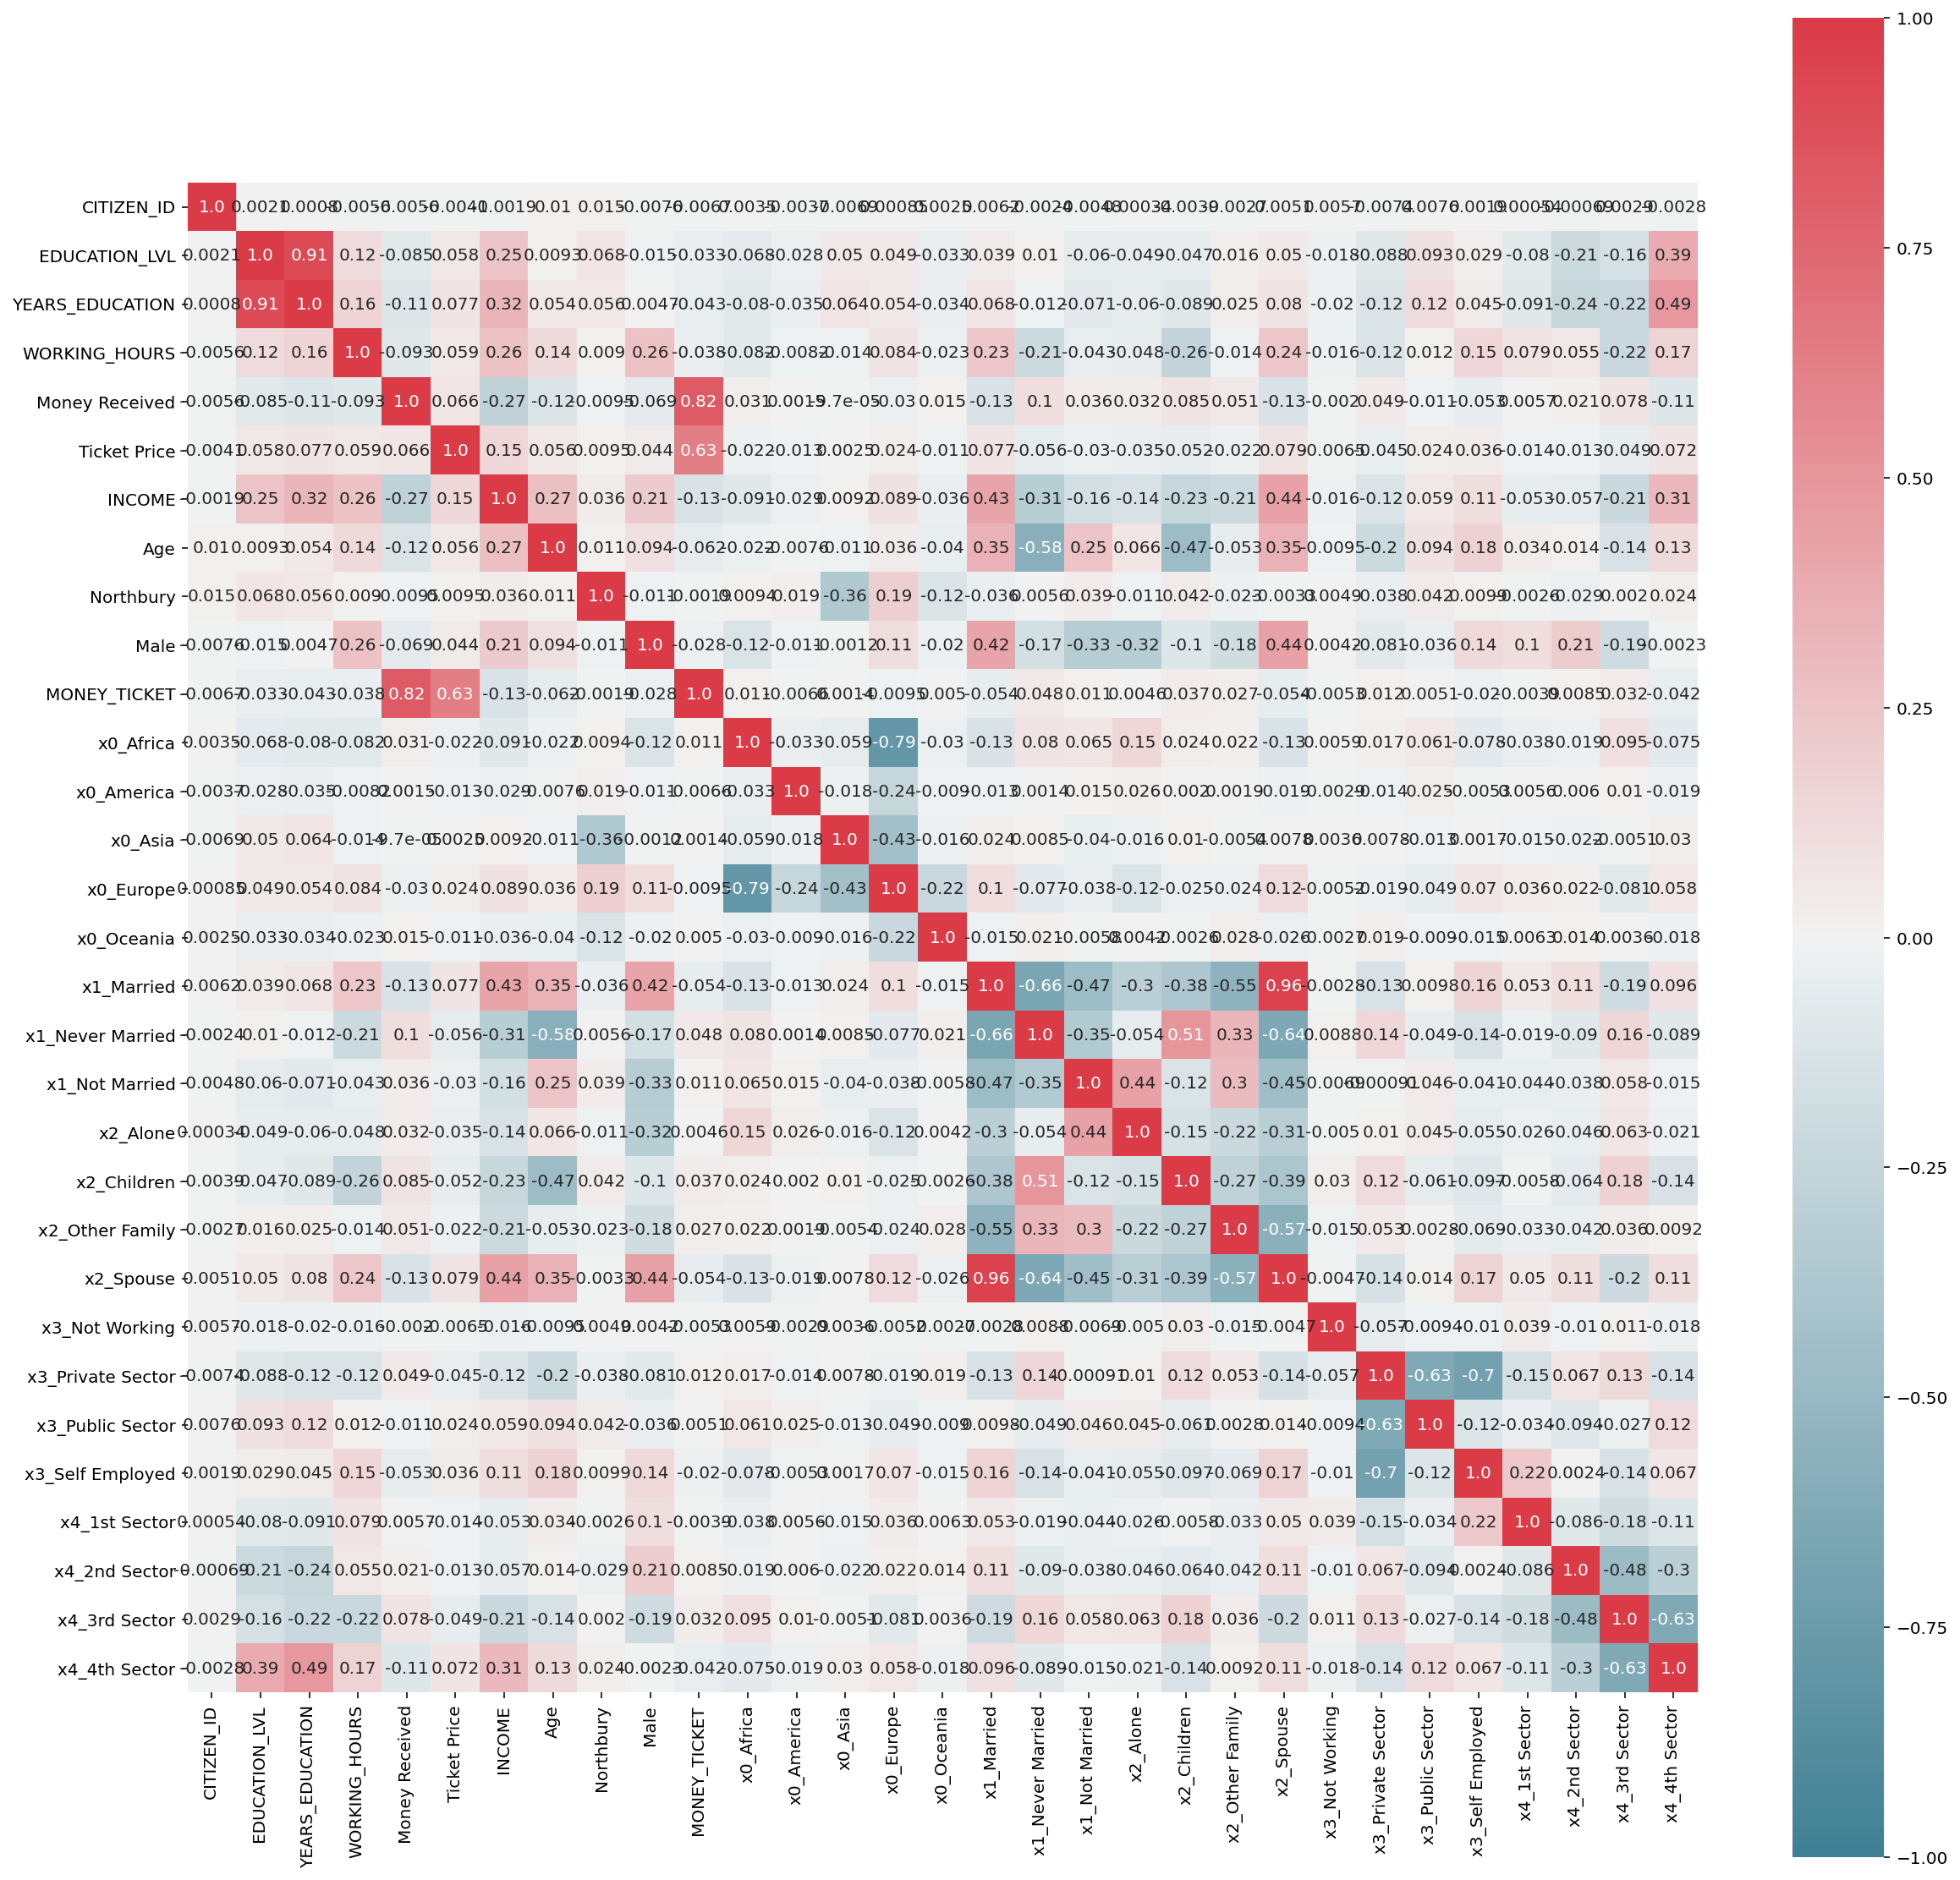

In [84]:
train_encoding_corr=train_encoding.corr(method = "spearman")
plt.figure(figsize=(20,20))
sns.heatmap(data = train_encoding_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

In [75]:
X_train, X_val, y_train, y_val = train_test_split(data_newland, target_newland, test_size = 0.60, stratify = target_newland, random_state = 15)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, stratify = y_val, random_state = 15)

# **Data Standardization**

In [76]:
from sklearn.neural_network import MLPClassifier

In [77]:
classifier = MLPClassifier().fit(X_train, y_train)

In [78]:
classifier.score(X_test, y_test)

0.7918154761904762

In [79]:
min_max1 = MinMaxScaler().fit(X_train)

In [80]:
min_max1_X_train = min_max1.transform(X_train)
min_max1_X_test = min_max1.transform(X_test)
model_min_max1 = MLPClassifier().fit(min_max1_X_train, y_train)
model_min_max1.score(min_max1_X_test, y_test)

0.8461309523809524

In [81]:
#DM
df_scaling = train_encoding.copy() 

scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_scaling)
scaled_feat

df_scaling = scaled_feat
df_scaling = pd.DataFrame(df_scaling)
df_scaling.columns = train_encoding.columns
df_scaling

,CITIZEN_ID,EDUCATION_LVL,YEARS_EDUCATION,WORKING_HOURS,Money Received,Ticket Price,INCOME,Age,Northbury,Male,...,x2_Other Family,x2_Spouse,x3_Not Working,x3_Private Sector,x3_Public Sector,x3_Self Employed,x4_1st Sector,x4_2nd Sector,x4_3rd Sector,x4_4th Sector
0,0.000000,0.8,0.578947,0.397959,1.000000,0.424225,1.0,0.383562,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000045,0.4,0.526316,0.397959,1.000000,0.000000,1.0,0.342466,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000089,0.4,0.526316,0.459184,1.000000,0.433184,1.0,0.301370,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000134,0.0,0.473684,0.367347,0.956138,0.000000,1.0,0.630137,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000179,1.0,1.000000,0.448980,1.000000,0.000000,1.0,0.219178,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,0.999821,0.4,0.526316,0.397959,1.000000,0.000000,0.0,0.109589,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22396,0.999866,0.4,0.526316,0.346939,1.000000,0.000000,0.0,0.082192,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22397,0.999911,0.8,0.789474,0.397959,0.978260,0.000000,0.0,0.123288,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22398,0.999955,0.8,0.736842,0.908163,1.000000,0.000000,1.0,0.273973,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# **Feature Selection**

# **Artificial Resampling**

# **Model Exploration**

# **Final Model**

# **Assess**

# **Limitations and Conclusions**